In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
epoch_key = "bon", 3, 2

In [3]:
from src.standard_decoder import load_data

(
    linear_position,
    multiunit_dfs,
    position_info,
    ripple_times,
    track_graph,
    center_well_id,
) = load_data(epoch_key)

Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [4]:
from src.standard_decoder import fit_mark_likelihood

(
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    place_bin_centers,
    place_bin_edges,
    is_track_interior,
    distance_between_nodes,
    place_bin_center_ind_to_node,
    place_bin_center_2D_position,
    place_bin_edges_2D_position,
    centers_shape,
    edges,
    track_graph1,
    place_bin_center_ind_to_edge_id,
    nodes_df,
) = fit_mark_likelihood(linear_position, multiunit_dfs, track_graph, center_well_id)

In [5]:
import xarray as xr
import os
from src.parameters import PROCESSED_DATA_DIR

from replay_trajectory_classification import ClusterlessClassifier

data_type, dim = "clusterless", "1D"
animal, day, epoch = epoch_key

results = xr.open_dataset(
    os.path.join(PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}.nc"),
    group=f"/{data_type}/{dim}/classifier/ripples/",
)

model_name = os.path.join(
    PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl"
)
classifier = ClusterlessClassifier.load_model(model_name)

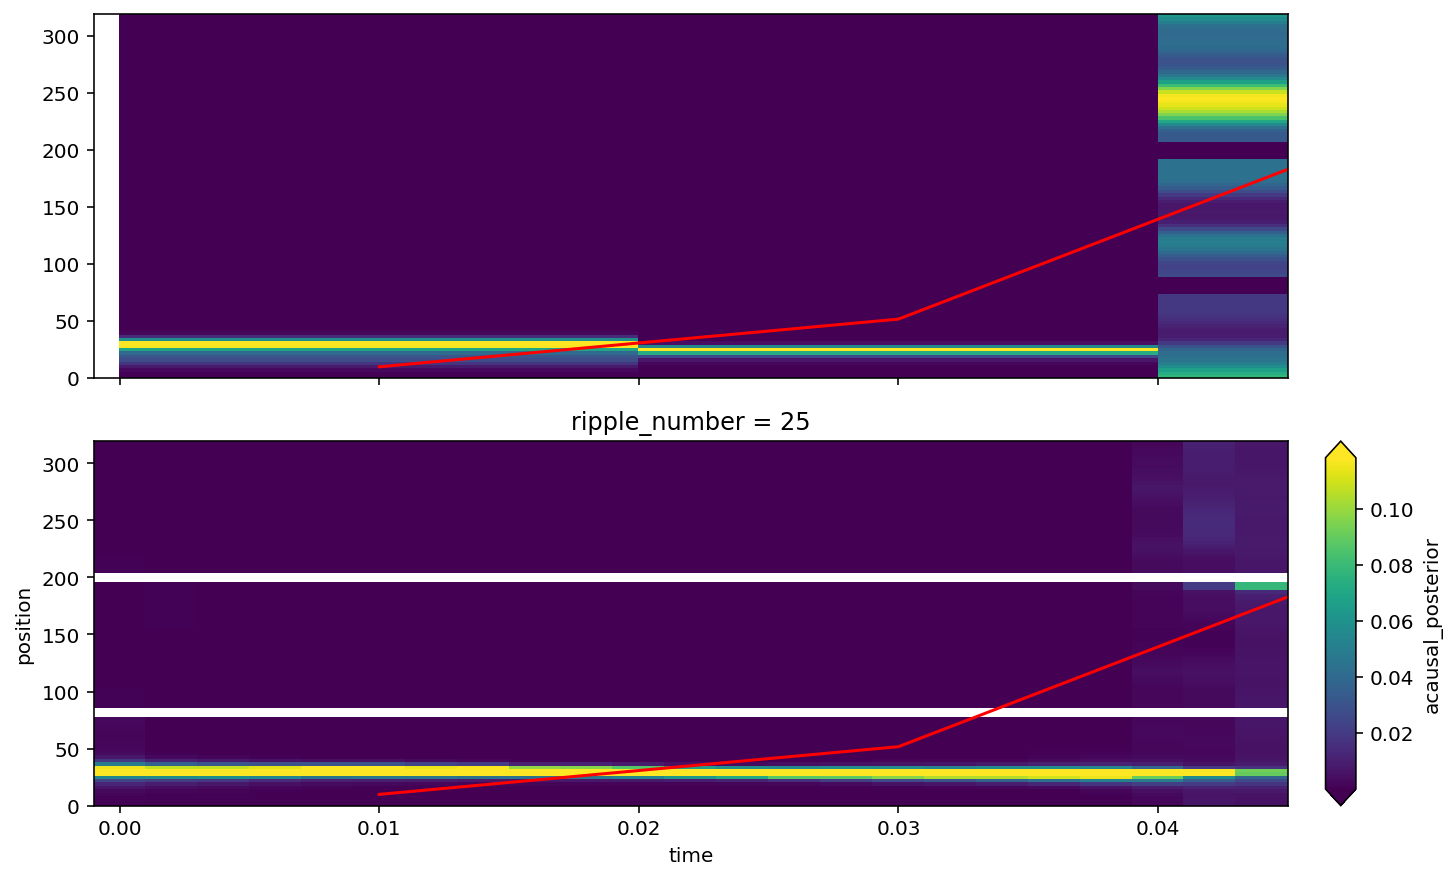

In [6]:
from src.standard_decoder import predict_clusterless_wtrack
import numpy as np
import matplotlib.pyplot as plt

ripple_number = 25
dt = 0.020

(
    time,
    likelihood,
    radon_velocity,
    radon_prediction,
    radon_score,
    isotonic_velocity,
    isotonic_prediction,
    isotonic_score,
    linear_velocity,
    linear_prediction,
    linear_score,
    map_velocity,
    map_prediction,
    map_score,
) = predict_clusterless_wtrack(
    ripple_times,
    ripple_number,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    place_bin_edges,
    track_graph1,
    place_bin_center_ind_to_node,
    dt=dt,
)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)
time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time + dt / 2, radon_prediction, color="red")

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction, color="red")

In [8]:
from src.shuffle import get_shuffled_pvalue, shuffle_likelihood_position_bins
from src.standard_decoder import (
    fit_mark_likelihood,
    load_data,
    predict_clusterless_wtrack,
    predict_mark_likelihood,
)
import numpy as np

ripple_number = 25
dt = 0.020
n_shuffles = 10

start_time, end_time = (
    ripple_times.loc[ripple_number].start_time / np.timedelta64(1, "s"),
    ripple_times.loc[ripple_number].end_time / np.timedelta64(1, "s"),
)

likelihood, time = predict_mark_likelihood(
    start_time,
    end_time,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    dt=dt,
)
(
    _,
    _,
    radon_speed,
    _,
    radon_score,
    isotonic_speed,
    _,
    isotonic_score,
    linear_speed,
    _,
    linear_score,
    map_speed,
    _,
    map_score,
) = predict_clusterless_wtrack(
    time,
    likelihood,
    place_bin_centers,
    is_track_interior,
    place_bin_edges,
    track_graph1,
    place_bin_center_ind_to_node,
    dt=dt,
)

shuffled_radon_score = np.zeros((n_shuffles,))
shuffled_isotonic_score = np.zeros((n_shuffles,))
shuffled_linear_score = np.zeros((n_shuffles,))
shuffled_map_score = np.zeros((n_shuffles,))

for shuffle_ind in range(n_shuffles):
    shuffled_likelihood = shuffle_likelihood_position_bins(
        likelihood, is_track_interior
    )
    (
        _,
        _,
        _,
        _,
        shuffled_radon_score[shuffle_ind],
        _,
        _,
        shuffled_isotonic_score[shuffle_ind],
        _,
        _,
        shuffled_linear_score[shuffle_ind],
        _,
        _,
        shuffled_map_score[shuffle_ind],
    ) = predict_clusterless_wtrack(
        time,
        shuffled_likelihood,
        place_bin_centers,
        is_track_interior,
        place_bin_edges,
        track_graph1,
        place_bin_center_ind_to_node,
        dt=dt,
    )
radon_pvalue = get_shuffled_pvalue(radon_score, shuffled_radon_score)
isotonic_pvalue = get_shuffled_pvalue(isotonic_score, shuffled_isotonic_score)
linear_pvalue = get_shuffled_pvalue(linear_score, shuffled_linear_score)
map_pvalue = get_shuffled_pvalue(map_score, shuffled_map_score)

In [15]:
%%timeit

n_shuffles = 1000
shuffled_radon_score = np.zeros((n_shuffles,))
shuffled_isotonic_score = np.zeros((n_shuffles,))
shuffled_linear_score = np.zeros((n_shuffles,))
shuffled_map_score = np.zeros((n_shuffles,))

for shuffle_ind in range(n_shuffles):
    shuffled_likelihood = shuffle_likelihood_position_bins(
        likelihood, is_track_interior
    )
    (
        _,
        _,
        _,
        _,
        shuffled_radon_score[shuffle_ind],
        _,
        _,
        shuffled_isotonic_score[shuffle_ind],
        _,
        _,
        shuffled_linear_score[shuffle_ind],
        _,
        _,
        shuffled_map_score[shuffle_ind],
    ) = predict_clusterless_wtrack(
        time,
        shuffled_likelihood,
        place_bin_centers,
        is_track_interior,
        place_bin_edges,
        track_graph1,
        place_bin_center_ind_to_node,
        dt=dt,
    )
radon_pvalue = get_shuffled_pvalue(radon_score, shuffled_radon_score)
isotonic_pvalue = get_shuffled_pvalue(isotonic_score, shuffled_isotonic_score)
linear_pvalue = get_shuffled_pvalue(linear_score, shuffled_linear_score)
map_pvalue = get_shuffled_pvalue(map_score, shuffled_map_score)

3min 31s ± 36.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
import dask


@dask.delayed
def get_shuffled_scores(
    time,
    likelihood,
    is_track_interior,
    place_bin_centers,
    place_bin_edges,
    track_graph1,
    place_bin_center_ind_to_node,
    dt,
):
    shuffled_likelihood = shuffle_likelihood_position_bins(
        likelihood, is_track_interior
    )
    (
        _,
        _,
        _,
        _,
        shuffled_radon_score,
        _,
        _,
        shuffled_isotonic_score,
        _,
        _,
        shuffled_linear_score,
        _,
        _,
        shuffled_map_score,
    ) = predict_clusterless_wtrack(
        time,
        shuffled_likelihood,
        place_bin_centers,
        is_track_interior,
        place_bin_edges,
        track_graph1,
        place_bin_center_ind_to_node,
        dt=dt,
    )

    return (
        shuffled_radon_score,
        shuffled_isotonic_score,
        shuffled_linear_score,
        shuffled_map_score,
    )

In [19]:
from dask.distributed import Client


client = Client(processes=True, threads_per_worker=1, n_workers=2, memory_limit="32GB")

In [39]:
with client:
    n_shuffles = 10
    output = []

    for shuffle_ind in range(n_shuffles):
        output.append(
            get_shuffled_scores(
                time,
                likelihood,
                is_track_interior,
                place_bin_centers,
                place_bin_edges,
                track_graph1,
                place_bin_center_ind_to_node,
                dt,
            )
        )

    output = np.asarray(dask.compute(*output))
    (
        shuffled_radon_score,
        shuffled_isotonic_score,
        shuffled_linear_score,
        shuffled_map_score,
    ) = output.T

In [40]:
output

array([[0.83021759, 0.99999604, 0.1719336 , 0.80465126],
       [1.13627305, 0.9999996 , 0.1393642 , 0.48177832],
       [1.45661455, 1.        , 0.30134208, 0.55524982],
       [0.64199989, 0.8676346 , 0.0117348 , 0.08801756],
       [0.87494144, 1.        , 0.29317015, 0.65293608],
       [0.75198298, 1.        , 0.28313592, 0.56453815],
       [1.01012604, 0.99098518, 0.2769084 , 0.56510781],
       [1.01660608, 1.        , 0.30145391, 0.52142216],
       [1.61537663, 1.        , 0.44852506, 0.79677351],
       [0.97788629, 0.99999851, 0.19375851, 0.50548766]])

In [31]:
a.shape

(1000,)

In [16]:
%%timeit

(
    _,
    _,
    radon_speed,
    _,
    radon_score,
    isotonic_speed,
    _,
    isotonic_score,
    linear_speed,
    _,
    linear_score,
    map_speed,
    _,
    map_score,
) = predict_clusterless_wtrack(
    time,
    likelihood,
    place_bin_centers,
    is_track_interior,
    place_bin_edges,
    track_graph1,
    place_bin_center_ind_to_node,
    dt=dt,
)

320 ms ± 95.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
radon_pvalue, isotonic_pvalue, linear_pvalue, map_pvalue

(0.6363636363636364,
 0.6363636363636364,
 0.45454545454545453,
 0.7272727272727273)

In [78]:
from src.standard_decoder import normalize_to_posterior

posterior = normalize_to_posterior(likelihood)

posterior[:, is_track_interior]

array([[3.12546854e-01, 2.38016162e-01, 1.52973899e-01, ...,
        2.62509985e-03, 4.24543574e-03, 6.07650930e-03],
       [1.77792955e-01, 2.46029616e-01, 2.53362126e-01, ...,
        3.04200875e-07, 3.22199453e-07, 3.26360701e-07],
       [6.03795814e-04, 1.72645437e-03, 6.05787881e-03, ...,
        2.84951976e-10, 6.05327982e-11, 1.50784922e-11],
       ...,
       [4.03904515e-01, 2.37288412e-01, 9.99474084e-02, ...,
        1.06472893e-02, 2.11440133e-02, 3.22529001e-02],
       [2.52252623e-01, 2.04388865e-01, 1.50829541e-01, ...,
        1.55707983e-02, 1.48491830e-02, 1.45292289e-02],
       [3.59241296e-01, 2.49971140e-01, 1.30816891e-01, ...,
        1.00490008e-03, 1.11712442e-03, 1.20312227e-03]])

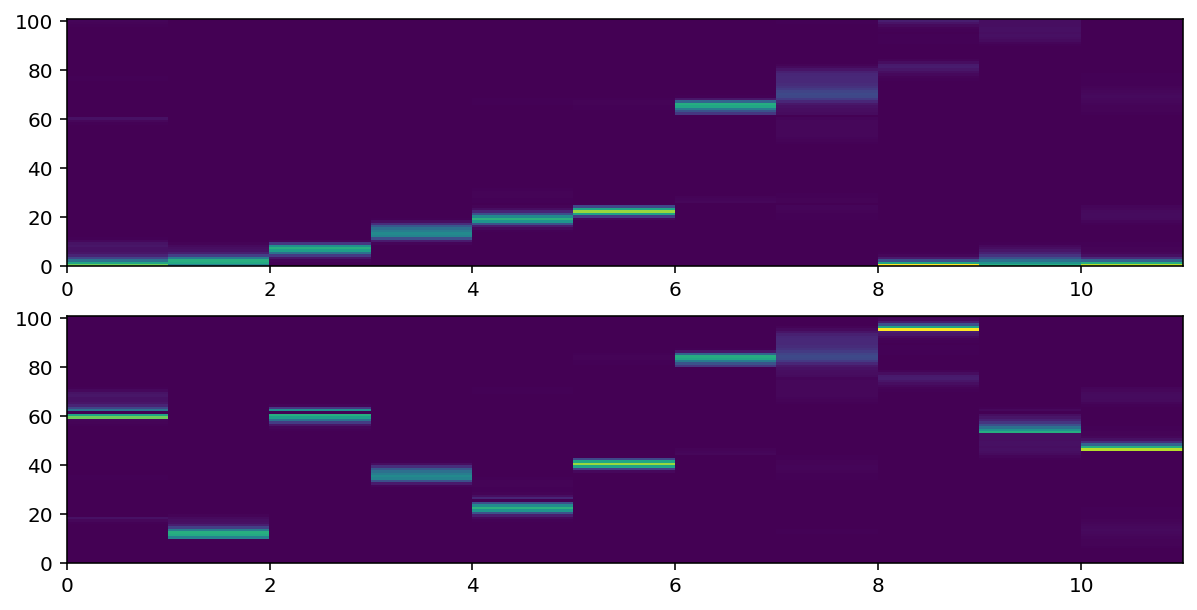

In [174]:
def shuffle_likelihood_position_bins(likelihood, is_track_interior):
    n_position_bins = likelihood.shape[1]
    midpoint = (n_position_bins - 1) // 2
    shuffled_likelihood = np.zeros_like(likelihood)

    shuffled_likelihood[:, is_track_interior] = np.stack(
        [
            np.roll(time_bin, shift=np.random.randint(low=-1 * midpoint, high=midpoint))
            for time_bin in likelihood[:, is_track_interior]
        ],
        axis=0,
    )
    return shuffled_likelihood


fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].pcolormesh(posterior.T)
axes[1].pcolormesh(shuffle_likelihood_position_bins(posterior, is_track_interior).T)

In [167]:
a = np.arange(20).reshape((2, 10))
shuffle_likelihood_position_bins(a, np.ones((10,), dtype=np.bool))

ValueError: shape mismatch: value array of shape (10,2) could not be broadcast to indexing result of shape (10,2)

In [168]:
%debug

> <ipython-input-164-3d76f0f8edb4>(11)shuffle_likelihood_position_bins()
      9             for time_bin in likelihood[:, is_track_interior]
     10         ],
---> 11         axis=1,
     12     )
     13     return shuffled_likelihood



ipdb>  ll


      1 def shuffle_likelihood_position_bins(likelihood, is_track_interior):
      2     n_position_bins = likelihood.shape[1]
      3     midpoint = (n_position_bins - 1) // 2
      4     shuffled_likelihood = np.zeros_like(likelihood)
      5 
      6     shuffled_likelihood[:, is_track_interior] = np.stack(
      7         [
      8             np.roll(time_bin, shift=np.random.randint(low=-1 * midpoint, high=midpoint))
      9             for time_bin in likelihood[:, is_track_interior]
     10         ],
---> 11         axis=1,
     12     )
     13     return shuffled_likelihood
     14 



ipdb>  np.stack(         [             np.roll(time_bin, shift=np.random.randint(low=-1 * midpoint, high=midpoint))             for time_bin in likelihood[:, is_track_interior]         ],         axis=1,     )


array([[ 3, 10],
       [ 4, 11],
       [ 5, 12],
       [ 6, 13],
       [ 7, 14],
       [ 8, 15],
       [ 9, 16],
       [ 0, 17],
       [ 1, 18],
       [ 2, 19]])


ipdb>  np.stack(         [             np.roll(time_bin, shift=np.random.randint(low=-1 * midpoint, high=midpoint))             for time_bin in likelihood[:, is_track_interior]         ],         axis=1,     ).shape


(10, 2)


ipdb>  q


In [160]:
a.shape

(2, 10)

In [84]:
np.arange(9).reshape((3, 3))

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [19]:
from src.standard_decoder import get_map_speed

get_map_speed(
    np.asarray(state_space_posterior.sum("state")),
    classifier.track_graph_,
    classifier.place_bin_center_ind_to_node_,
    np.mean(np.diff(state_space_posterior.time)),
)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

array([    0.        ,     0.        ,     0.        ,     0.        ,
        6663.28697244,  6663.28697244,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,   740.36521916,
         740.36521916,   740.36521916,   740.36521916,     0.        ,
         740.36521916,   740.36521916,   740.36521916,  1480.73043832,
        1480.73043832,   740.36521916,   740.36521916,   740.36521916,
         740.36521916,  1480.73043832,  1480.73043832,   740.36521916,
         740.36521916,   740.36521916,   740.36521916,   740.36521916,
         740.36521916,   740.36521916,     0.        ,     0.        ,
         740.36521916,   740.36521916,     0.        ,   740.36521916,
      

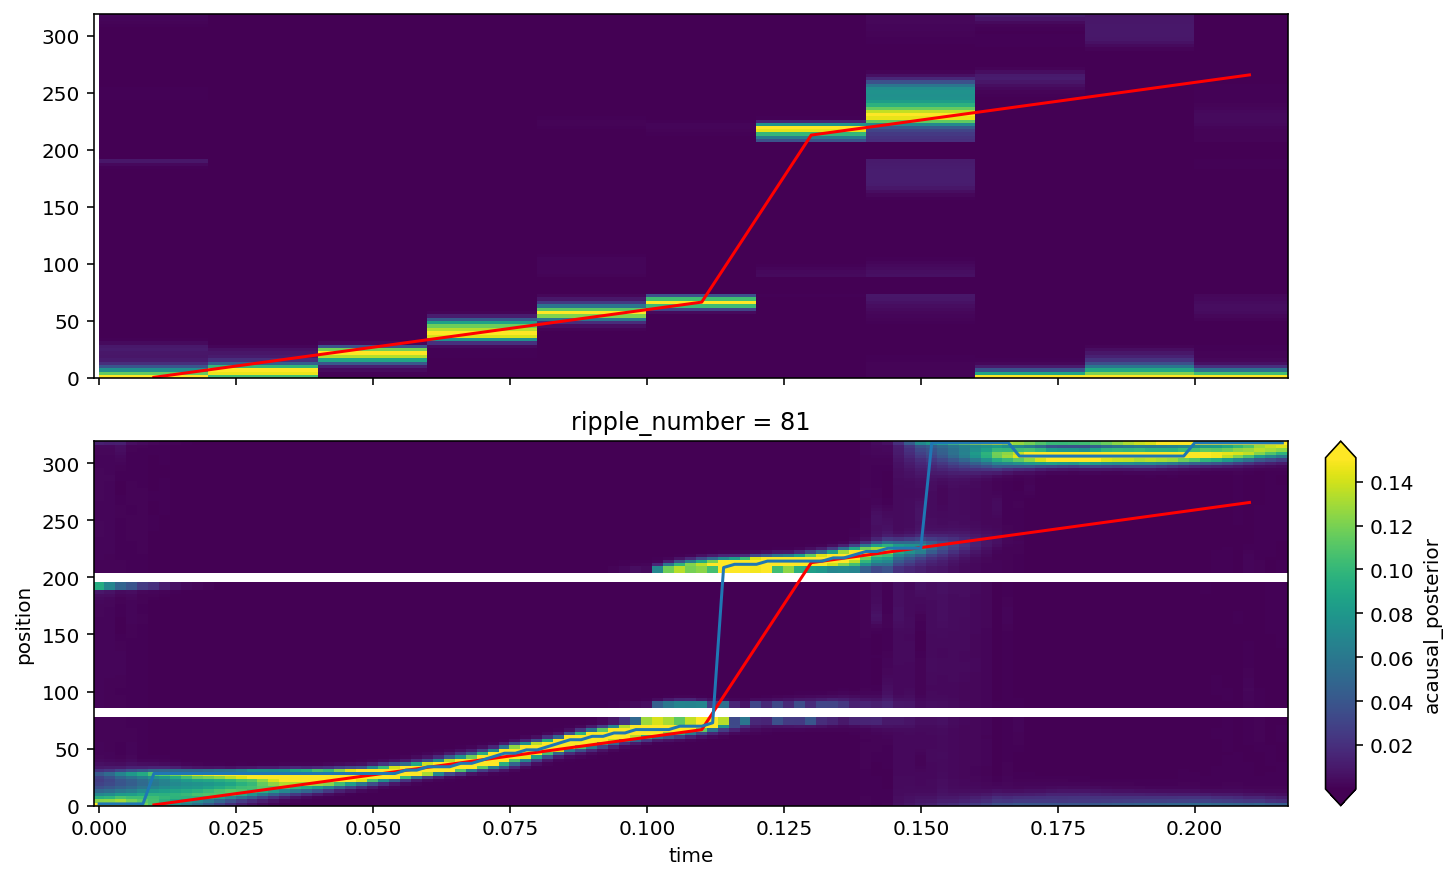

In [26]:
ripple_number = 81

(
    time,
    likelihood,
    radon_velocity,
    radon_prediction,
    radon_score,
    isotonic_velocity,
    isotonic_prediction,
    isotonic_score,
    linear_velocity,
    linear_prediction,
    linear_score,
    map_velocity,
    map_prediction,
    map_score,
) = predict_clusterless_wtrack(
    ripple_times,
    ripple_number,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    place_bin_edges,
    track_graph1,
    place_bin_center_ind_to_node,
    dt=dt,
)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)
time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time + dt / 2, radon_prediction, color="red")

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction, color="red")
axes[1].plot(
    state_space_posterior.time,
    state_space_posterior.position[
        state_space_posterior.sum("state", skipna=False).argmax("position").values
    ],
)
get_map_speed(
    np.asarray(state_space_posterior.sum("state")),
    classifier.track_graph_,
    classifier.place_bin_center_ind_to_node_,
    np.mean(np.diff(state_space_posterior.time)),
)

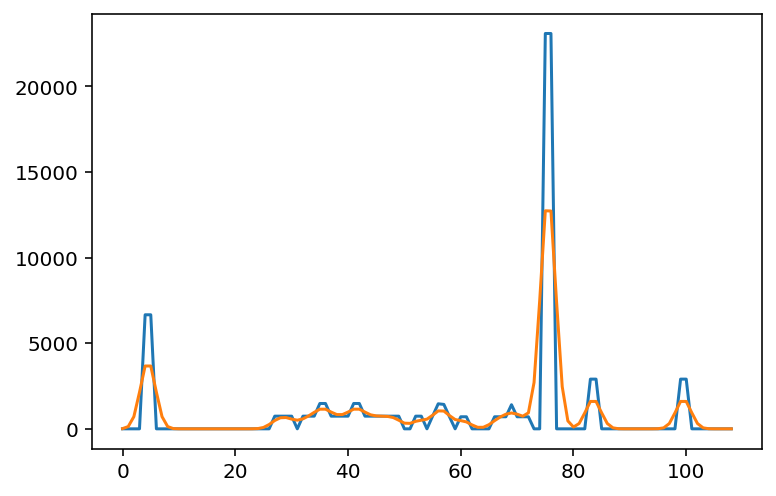

In [33]:
from src.analysis import gaussian_smooth


replay_speed = get_map_speed(
    np.asarray(state_space_posterior.sum("state")),
    classifier.track_graph_,
    classifier.place_bin_center_ind_to_node_,
    np.mean(np.diff(state_space_posterior.time)),
)

plt.plot(replay_speed)
SMOOTH_SIGMA = 0.0025
replay_speed = gaussian_smooth(replay_speed, SMOOTH_SIGMA, 500)
plt.plot(replay_speed)

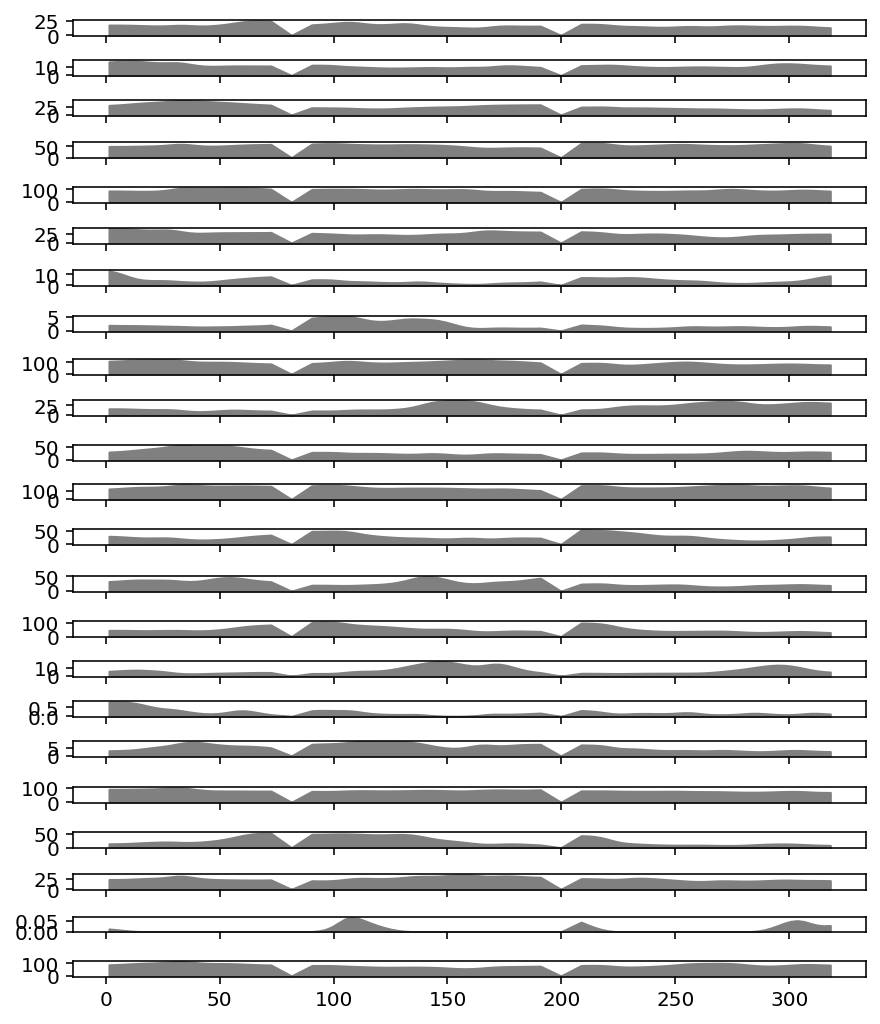

In [70]:
gpi = np.concatenate(classifier.ground_process_intensities_, axis=0)
n_tetrodes = gpi.shape[0]
fig, axes = plt.subplots(
    n_tetrodes, 1, sharex=True, constrained_layout=True, figsize=(6, 7)
)
for ax, g in zip(axes.flat, gpi):
    ax.fill_between(classifier.place_bin_centers_.squeeze(), g * 500, color="grey")

In [62]:
(np.sum(gpi > gpi.max(axis=0) * 0.8, axis=1)[classifier.is_track_interior_] > 0).mean()

1.0

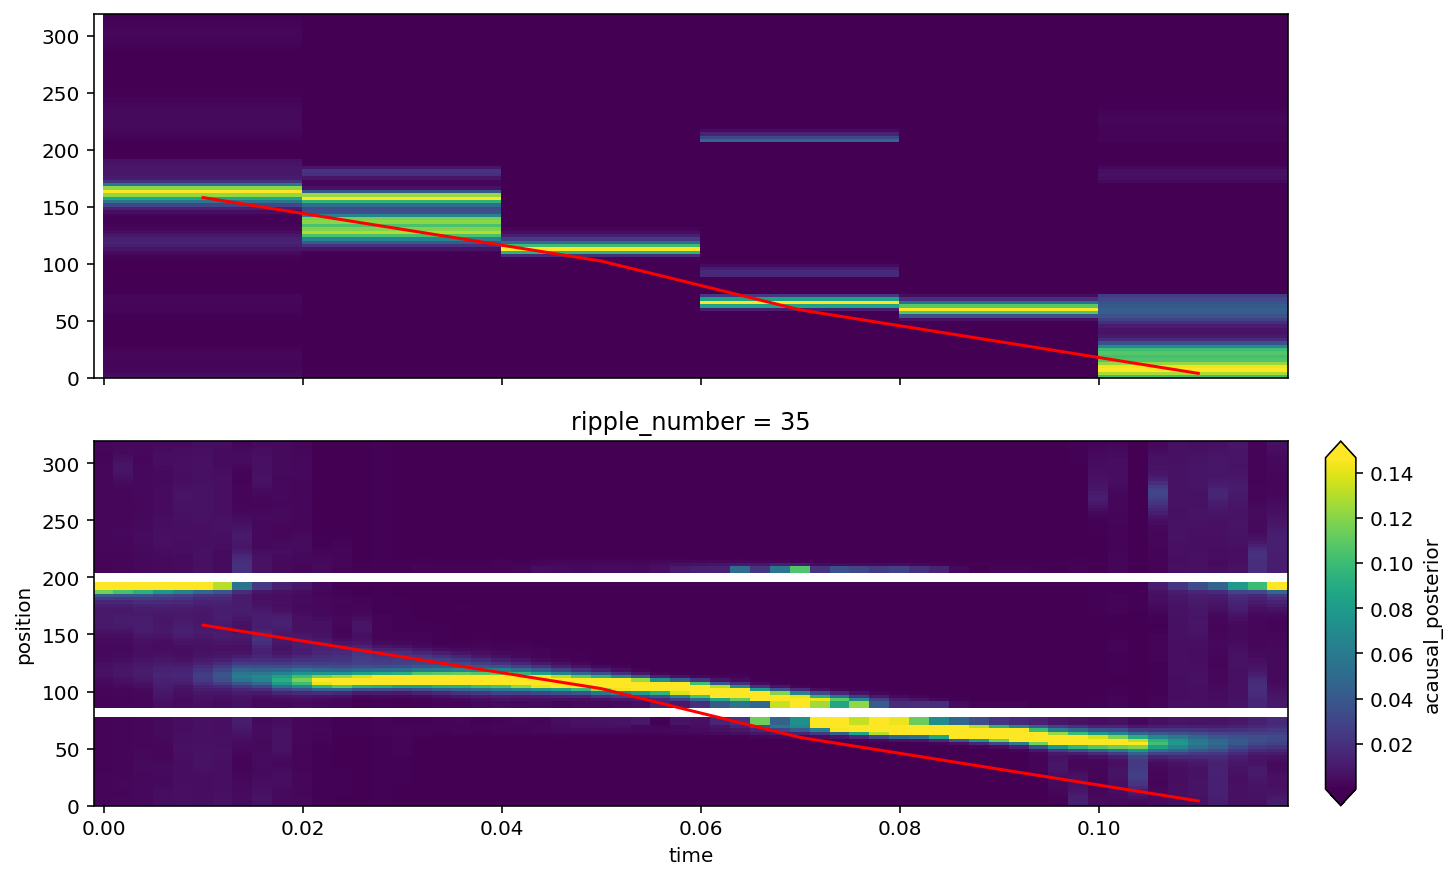

In [192]:
from src.standard_decoder import predict_clusterless_radon_wtrack

ripple_number = 35


(
    time,
    estimated_velocity,
    radon_prediction,
    radon_score,
    likelihood,
) = predict_clusterless_radon_wtrack(
    ripple_times,
    ripple_number,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    place_bin_edges,
    dt=dt,
)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)
time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time + dt / 2, radon_prediction, color="red")

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction, color="red")

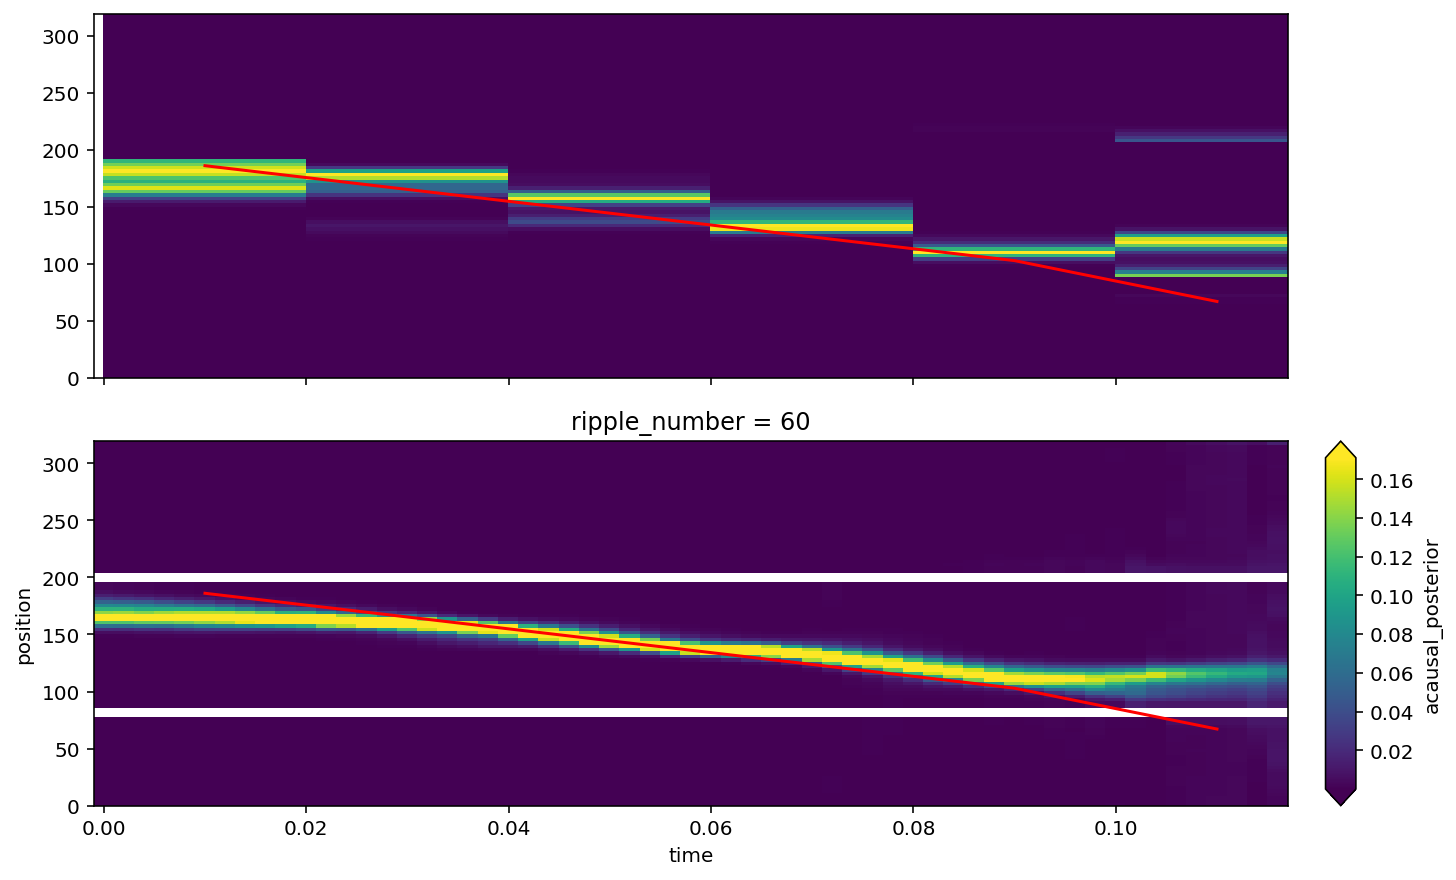

In [193]:
from src.standard_decoder import predict_clusterless_radon_wtrack

ripple_number = 60


(
    time,
    estimated_velocity,
    radon_prediction,
    radon_score,
    likelihood,
) = predict_clusterless_radon_wtrack(
    ripple_times,
    ripple_number,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    place_bin_edges,
    dt=dt,
)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)
time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time + dt / 2, radon_prediction, color="red")

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction, color="red")

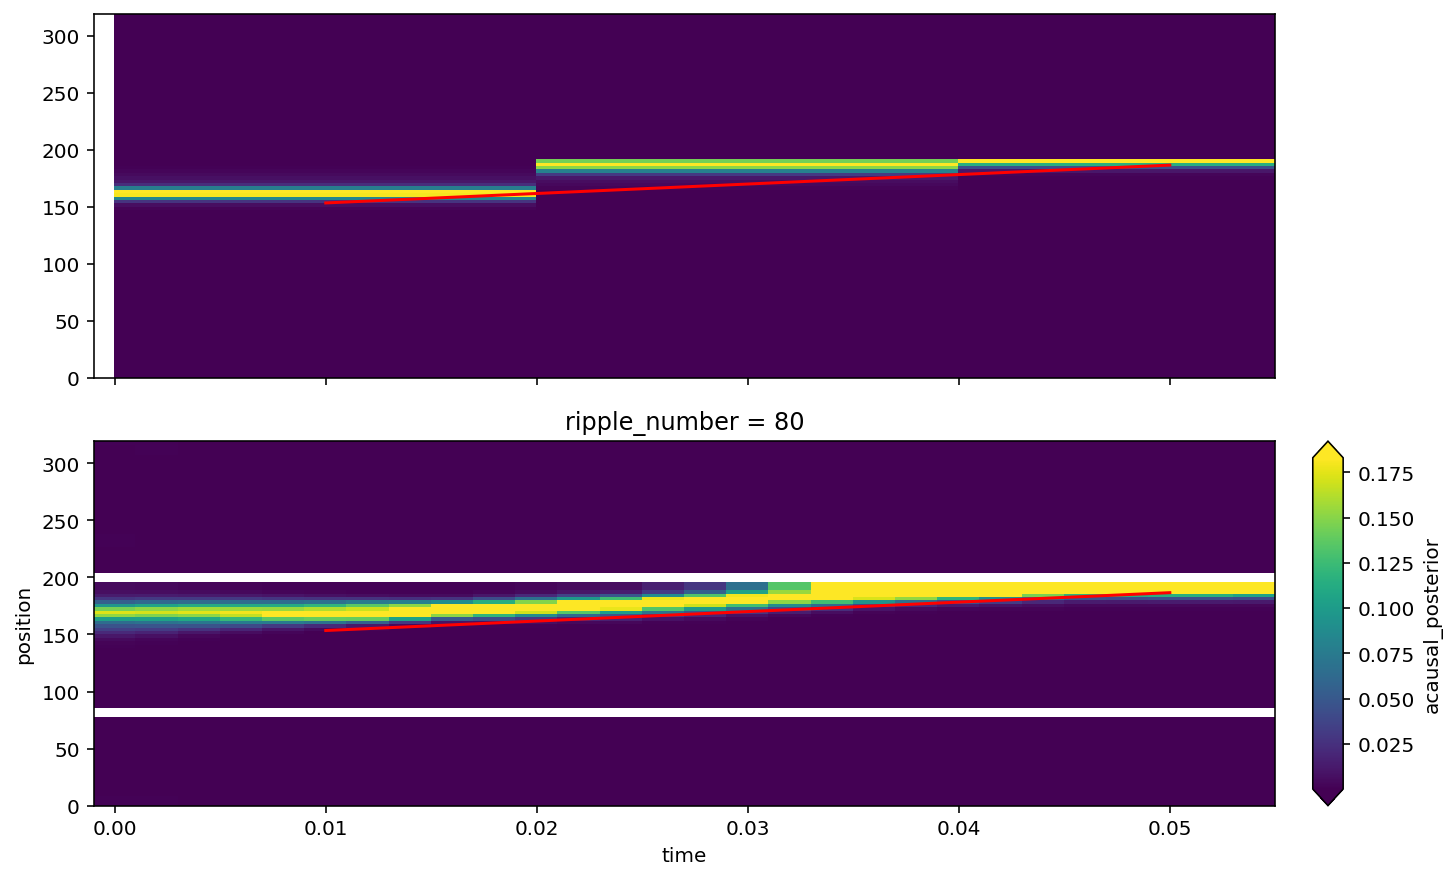

In [194]:
from src.standard_decoder import predict_clusterless_radon_wtrack

ripple_number = 80


(
    time,
    estimated_velocity,
    radon_prediction,
    radon_score,
    likelihood,
) = predict_clusterless_radon_wtrack(
    ripple_times,
    ripple_number,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    place_bin_edges,
    dt=dt,
)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)
time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time + dt / 2, radon_prediction, color="red")

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction, color="red")

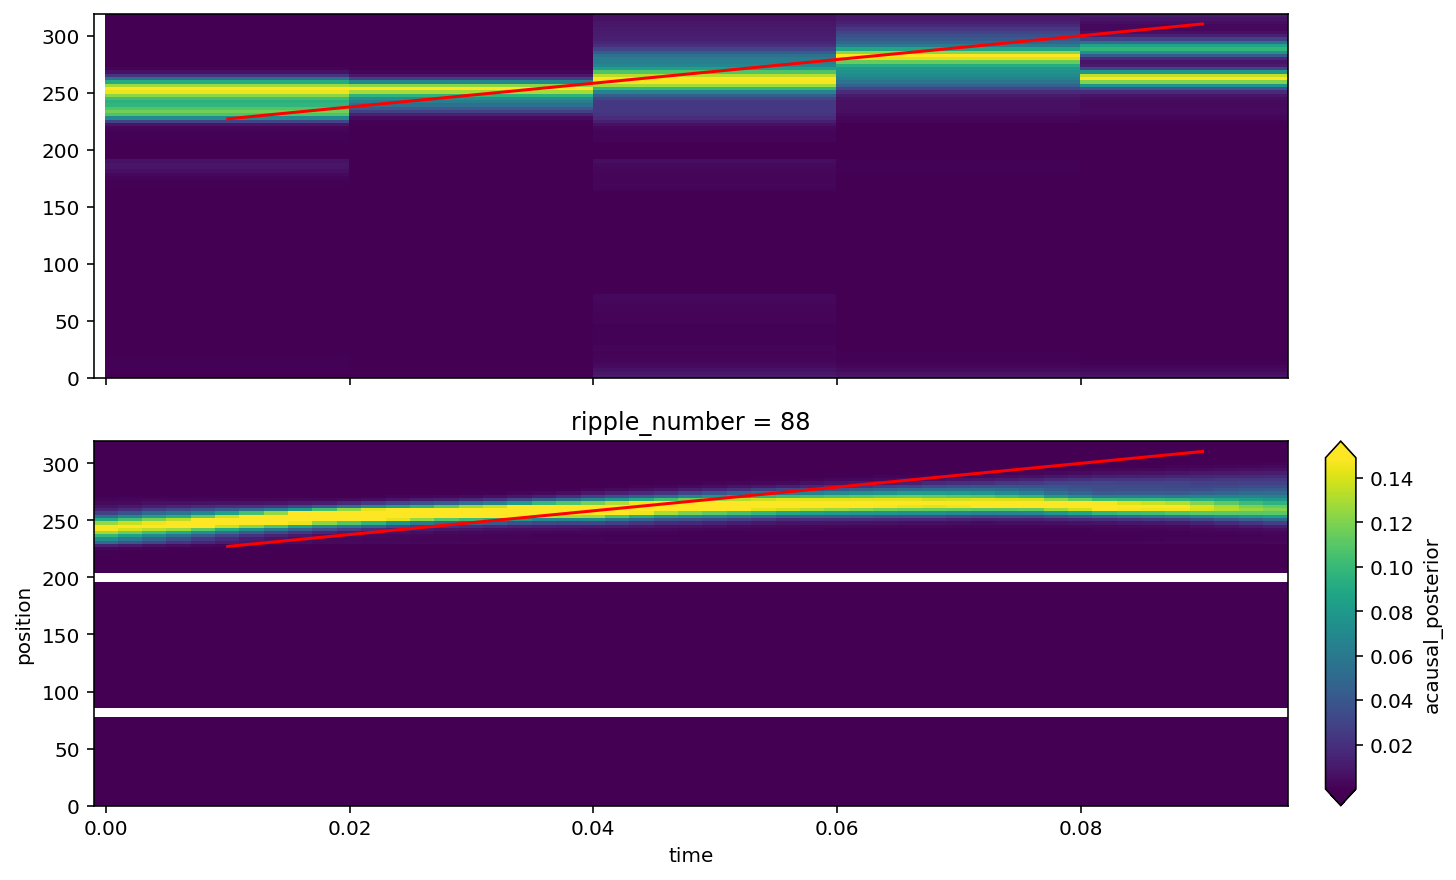

In [195]:
from src.standard_decoder import predict_clusterless_radon_wtrack

ripple_number = 88


(
    time,
    estimated_velocity,
    radon_prediction,
    radon_score,
    likelihood,
) = predict_clusterless_radon_wtrack(
    ripple_times,
    ripple_number,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    place_bin_edges,
    dt=dt,
)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)
time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time + dt / 2, radon_prediction, color="red")

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction, color="red")

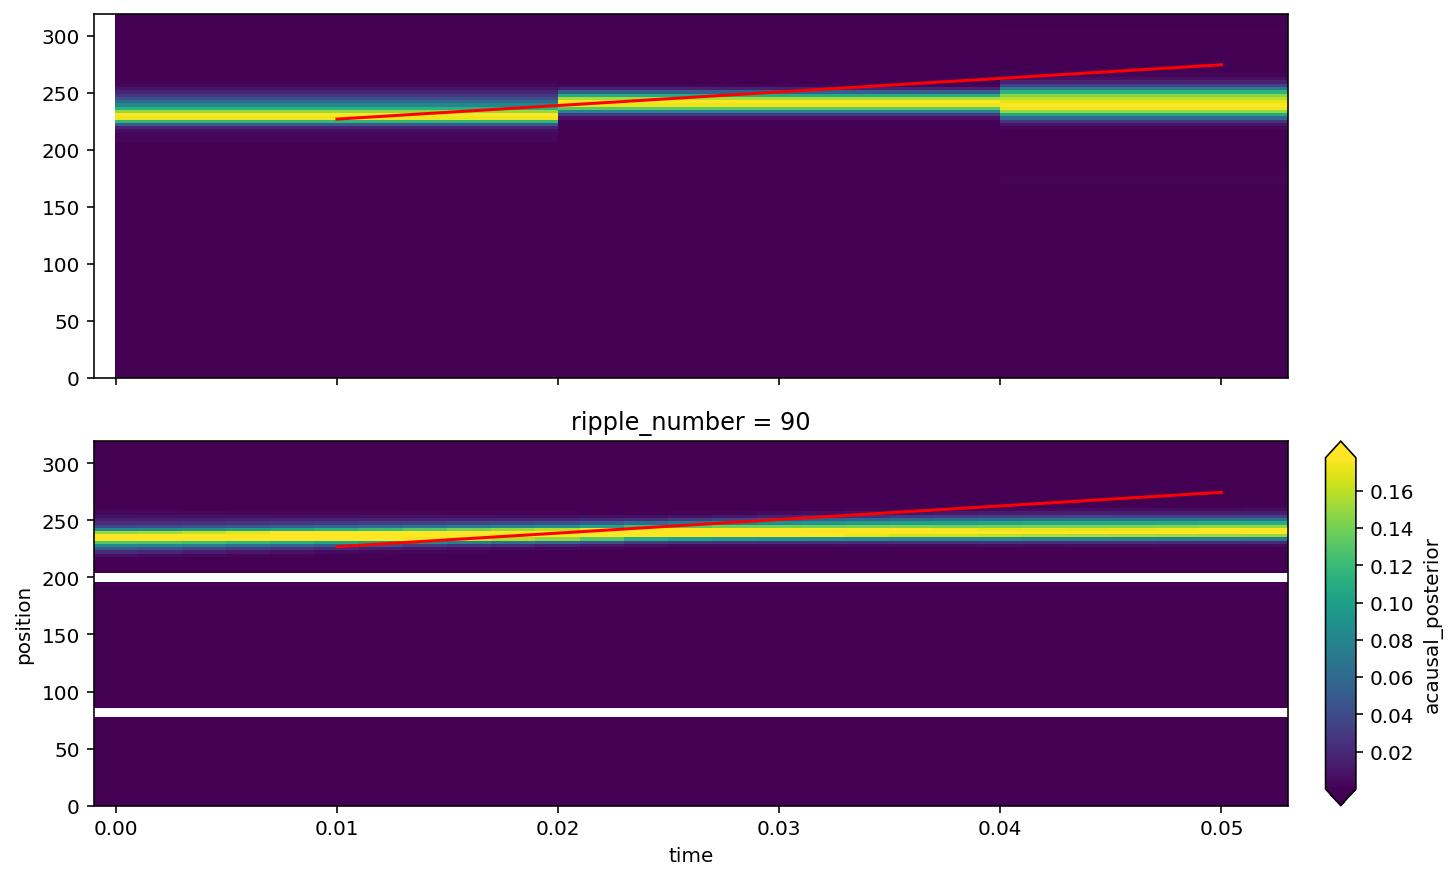

In [196]:
from src.standard_decoder import predict_clusterless_radon_wtrack

ripple_number = 90


(
    time,
    estimated_velocity,
    radon_prediction,
    radon_score,
    likelihood,
) = predict_clusterless_radon_wtrack(
    ripple_times,
    ripple_number,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    place_bin_edges,
    dt=dt,
)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)
time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time + dt / 2, radon_prediction, color="red")

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction, color="red")

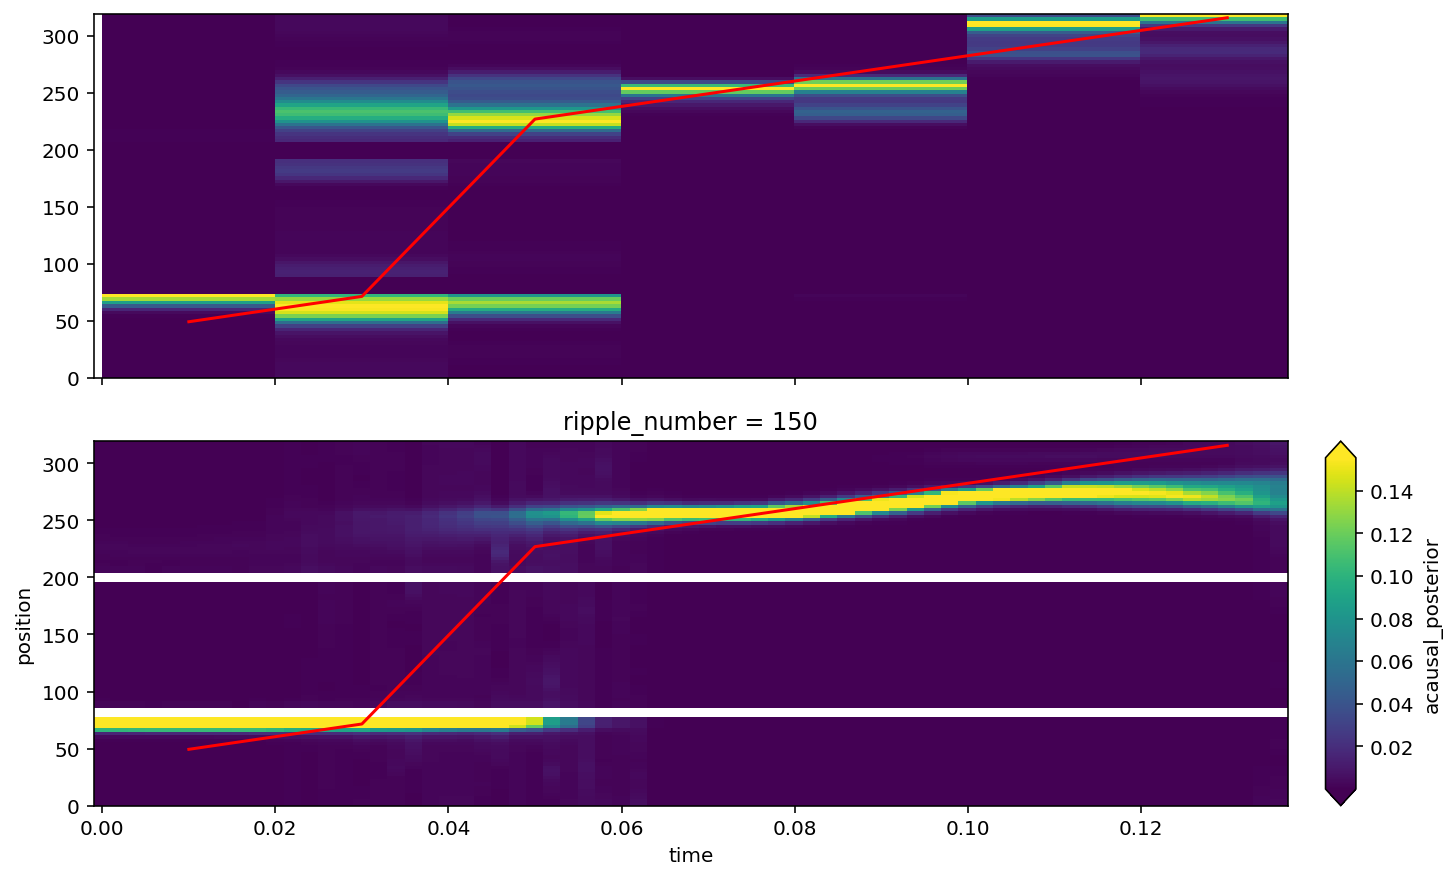

In [197]:
from src.standard_decoder import predict_clusterless_radon_wtrack

ripple_number = 150


(
    time,
    estimated_velocity,
    radon_prediction,
    radon_score,
    likelihood,
) = predict_clusterless_radon_wtrack(
    ripple_times,
    ripple_number,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    place_bin_edges,
    dt=dt,
)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)
time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time + dt / 2, radon_prediction, color="red")

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction, color="red")

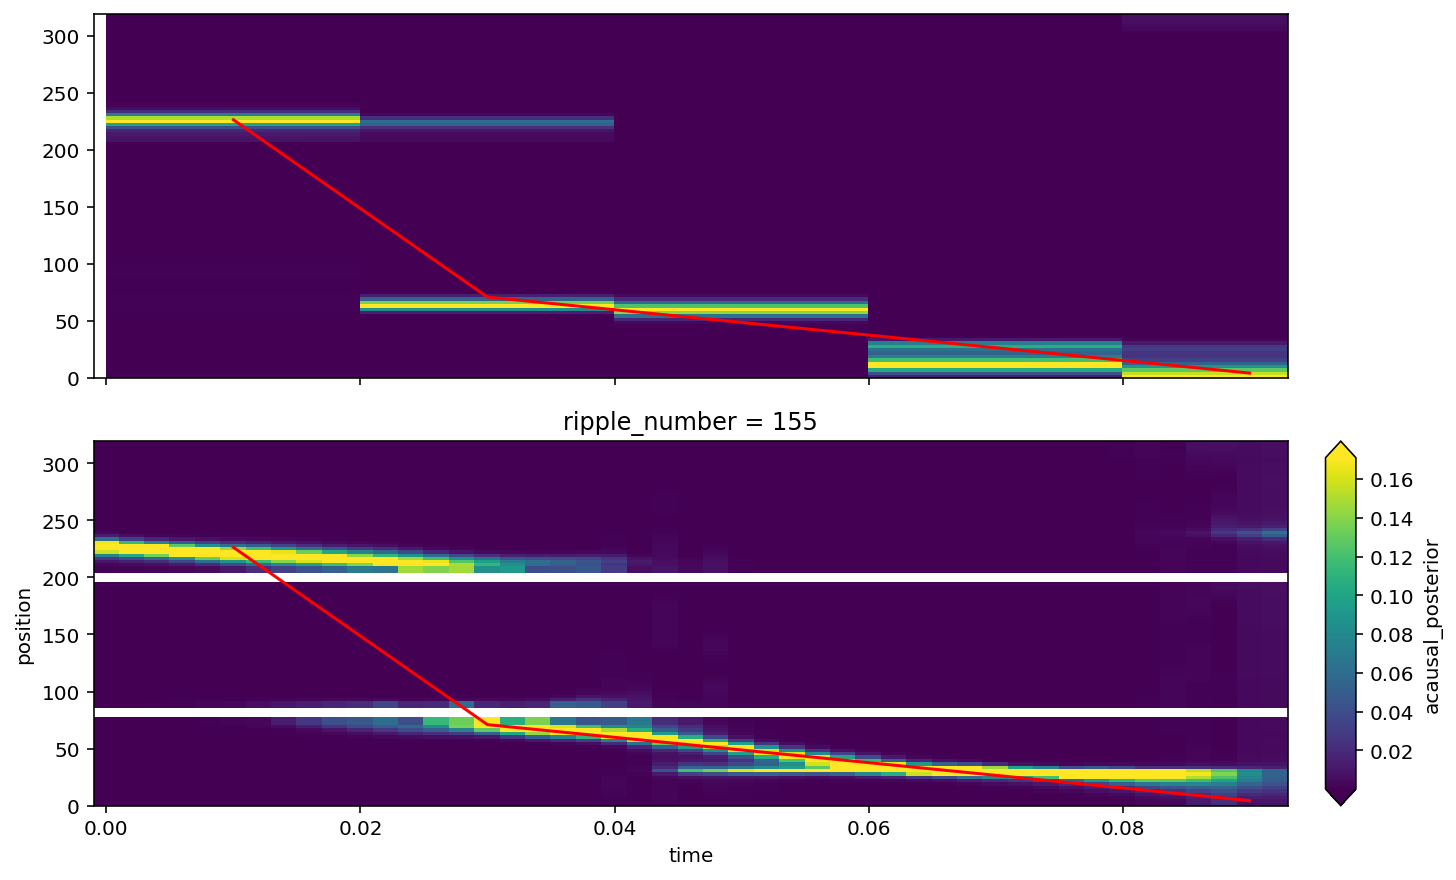

In [198]:
from src.standard_decoder import predict_clusterless_radon_wtrack

ripple_number = 155


(
    time,
    estimated_velocity,
    radon_prediction,
    radon_score,
    likelihood,
) = predict_clusterless_radon_wtrack(
    ripple_times,
    ripple_number,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    place_bin_edges,
    dt=dt,
)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)
time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time + dt / 2, radon_prediction, color="red")

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction, color="red")

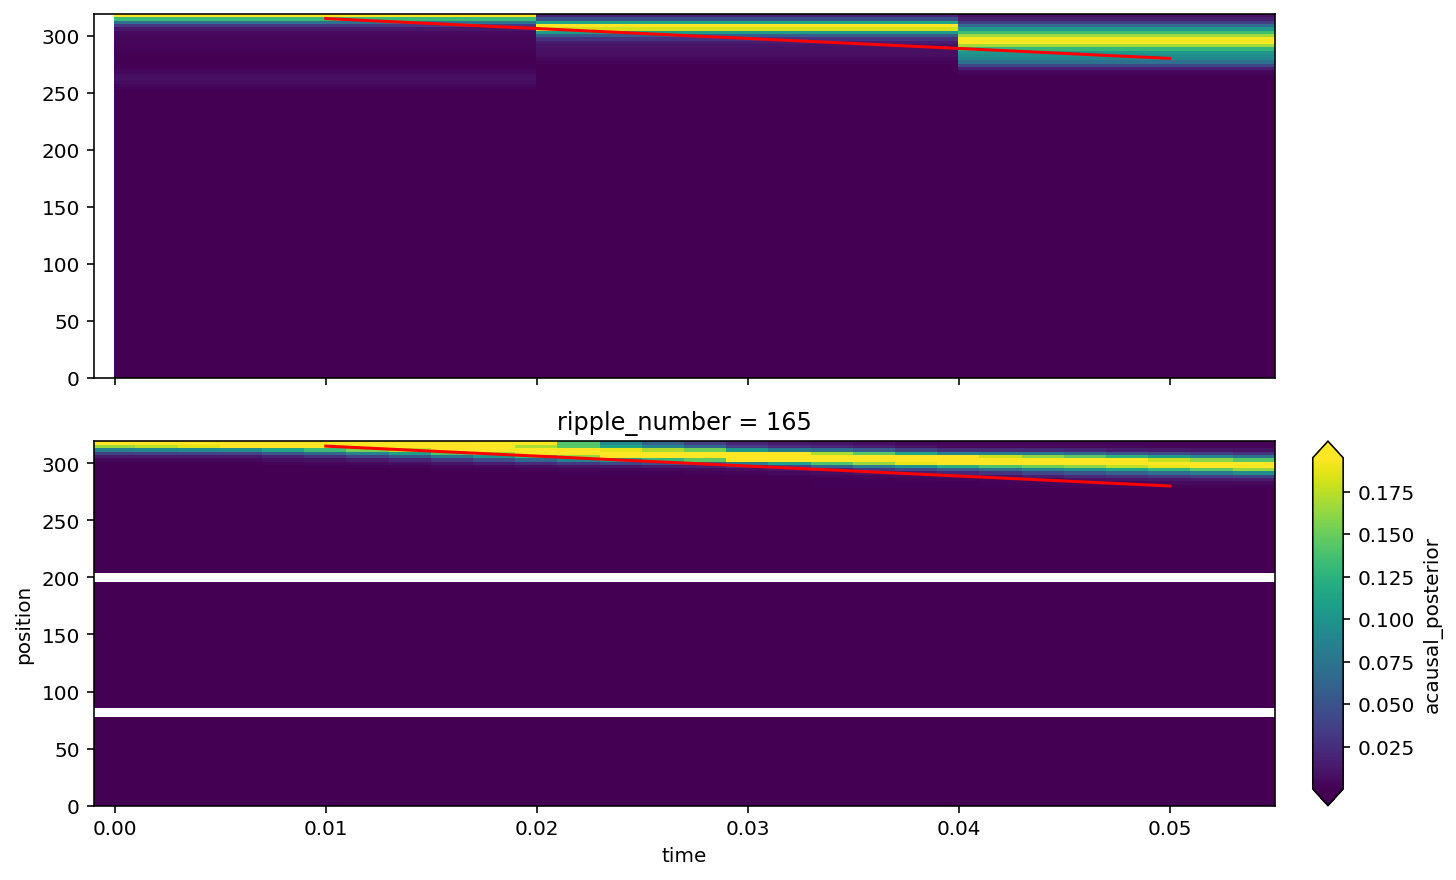

In [200]:
from src.standard_decoder import predict_clusterless_radon_wtrack

ripple_number = 165


(
    time,
    estimated_velocity,
    radon_prediction,
    radon_score,
    likelihood,
) = predict_clusterless_radon_wtrack(
    ripple_times,
    ripple_number,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    place_bin_edges,
    dt=dt,
)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)
time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time + dt / 2, radon_prediction, color="red")

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction, color="red")

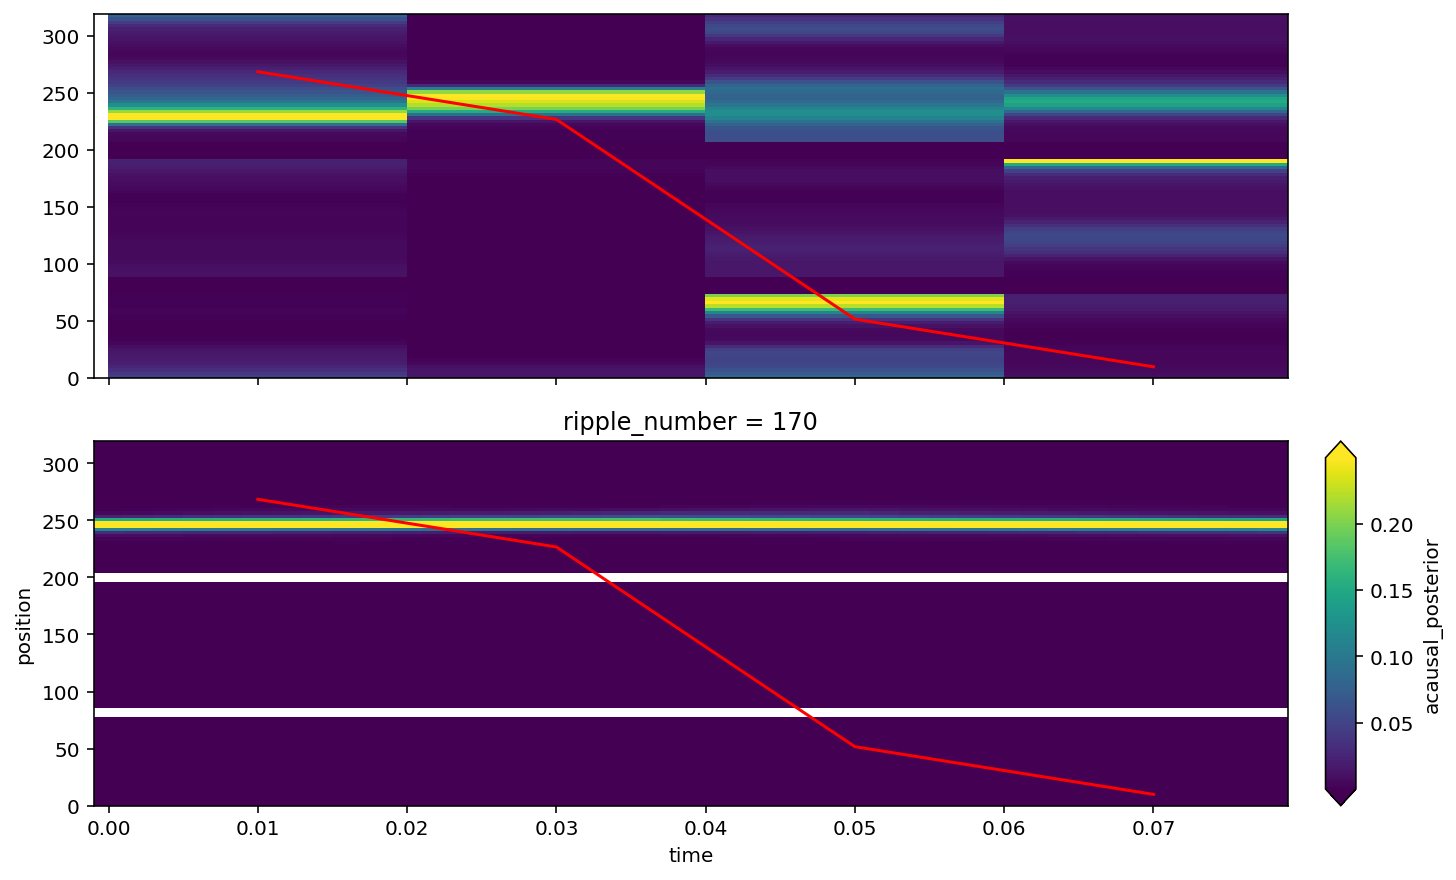

In [201]:
from src.standard_decoder import predict_clusterless_radon_wtrack

ripple_number = 170


(
    time,
    estimated_velocity,
    radon_prediction,
    radon_score,
    likelihood,
) = predict_clusterless_radon_wtrack(
    ripple_times,
    ripple_number,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    place_bin_edges,
    dt=dt,
)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)
time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time + dt / 2, radon_prediction, color="red")

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction, color="red")

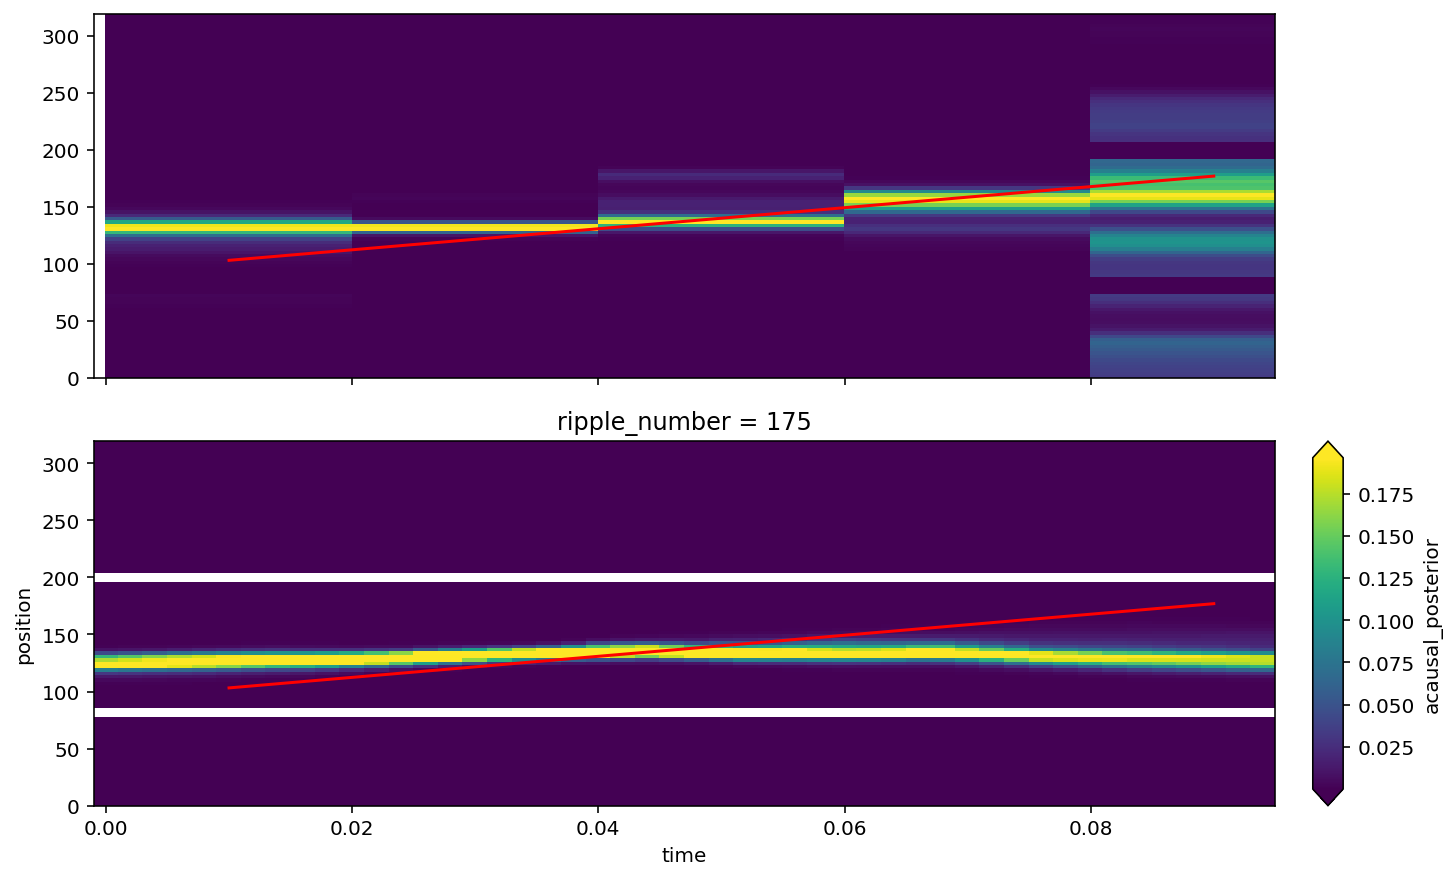

In [202]:
from src.standard_decoder import predict_clusterless_radon_wtrack

ripple_number = 175


(
    time,
    estimated_velocity,
    radon_prediction,
    radon_score,
    likelihood,
) = predict_clusterless_radon_wtrack(
    ripple_times,
    ripple_number,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    place_bin_edges,
    dt=dt,
)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)
time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time + dt / 2, radon_prediction, color="red")

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction, color="red")

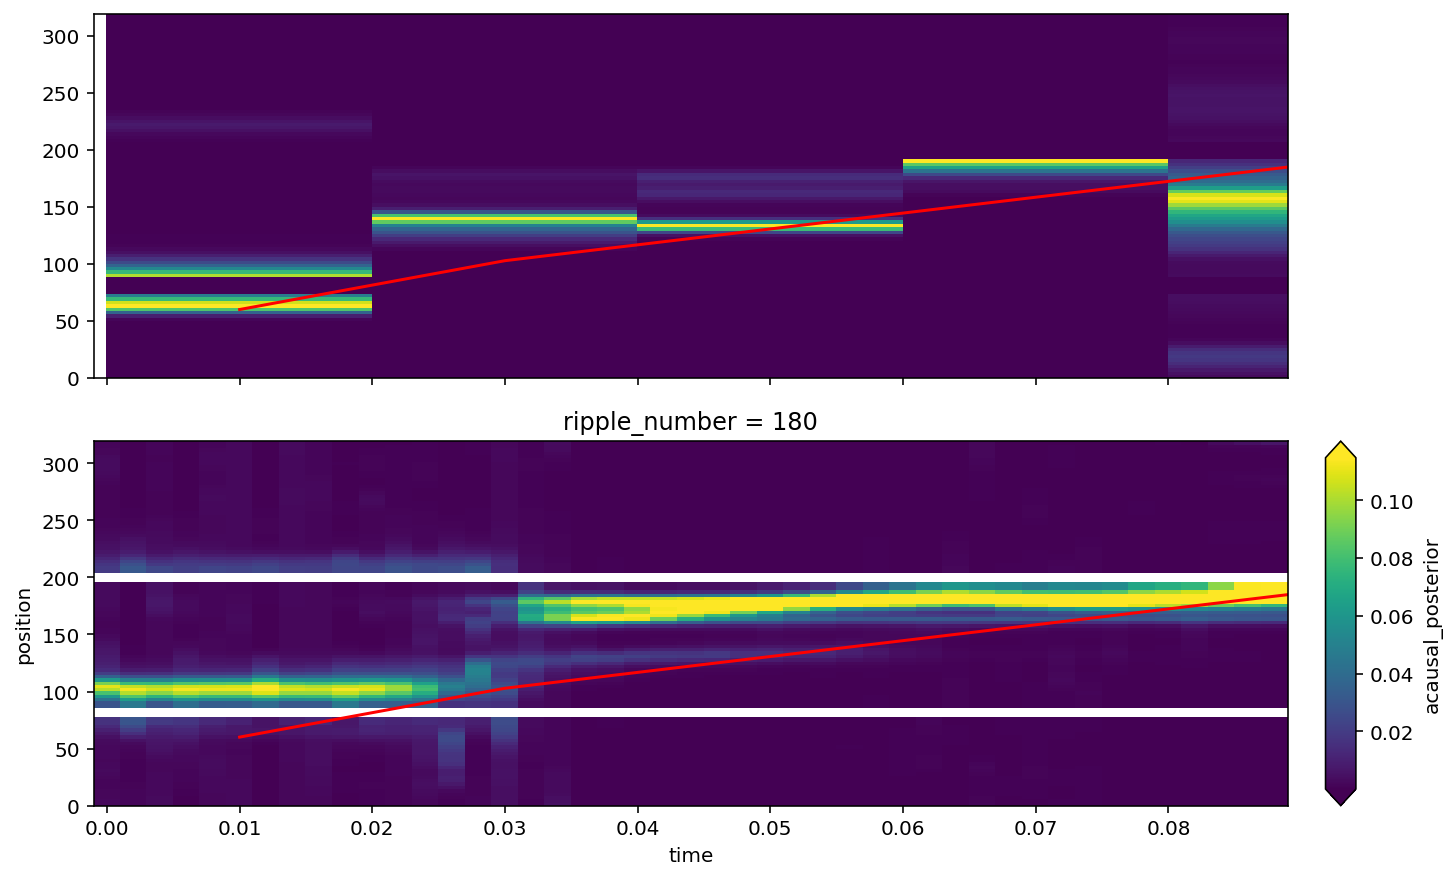

In [203]:
from src.standard_decoder import predict_clusterless_radon_wtrack

ripple_number = 180


(
    time,
    estimated_velocity,
    radon_prediction,
    radon_score,
    likelihood,
) = predict_clusterless_radon_wtrack(
    ripple_times,
    ripple_number,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    place_bin_edges,
    dt=dt,
)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)
time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time + dt / 2, radon_prediction, color="red")

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction, color="red")

In [46]:
n_time_bins = np.ceil((end_time - start_time) / dt).astype(int)
time_bin_edges = start_time + np.arange(n_time_bins + 1) * dt
n_place_bins = len(place_bin_centers)

log_likelihood = np.zeros((n_time_bins, n_place_bins))
interior_bin_inds = np.nonzero(is_track_interior)[0]

multiunit_df = multiunit_dfs[4]
spike_times = multiunit_df.index.total_seconds()
multiunit_df = multiunit_df.iloc[
    (spike_times >= start_time) & (spike_times <= end_time), :4
]

time_index = np.digitize(multiunit_df.index.total_seconds(), time_bin_edges[1:-1])
multiunit_df["time_bin_ind"] = time_index
multiunit_df

,channel_1_max,channel_2_max,channel_3_max,channel_4_max,time_bin_ind
time,,,,,
01:08:31.569000,64.522425,35.001018,61.815827,59.093077,0
01:08:31.573100,69.432567,24.221857,30.774754,50.807110,0
01:08:31.574300,56.700145,22.568041,32.508601,41.844501,0
01:08:31.576300,33.570537,30.323052,51.493686,35.328080,0
01:08:31.577900,70.604432,26.528437,27.025026,40.015458,0
01:08:31.583500,64.752161,25.647922,30.892861,44.421911,0
01:08:31.589500,53.941234,32.106798,42.720407,35.368558,1
01:08:31.591600,70.015442,32.797903,41.468421,58.414022,1
01:08:31.593300,67.847155,39.521876,43.756962,62.030770,1


,channel_1_max,channel_2_max,channel_3_max,channel_4_max,linear_position,speed,time_bin_ind


In [90]:
from src.standard_decoder import (
    isotonic_regression,
    map_estimate,
    weighted_correlation,
    linear_regression,
    normalize_to_posterior,
)
from scipy.stats import multivariate_normal


dt = 0.020
dp = 1

starting_position = 250.0
velocity = -100
time = np.arange(21) * dt
true_replay_position = starting_position + velocity * time

place_bin_edges = np.arange(0, 301 + dp, dp)
place_bin_centers = place_bin_edges[:-1] + np.diff(place_bin_edges) / 2

likelihood = np.zeros((time.shape[0], place_bin_centers.shape[0]))
p_ind = np.digitize(true_replay_position, place_bin_edges.squeeze()[1:-1])
for t_ind, peak in enumerate(place_bin_centers[p_ind]):
    likelihood[t_ind, :] = multivariate_normal(mean=peak, cov=144).pdf(
        place_bin_centers.squeeze()
    )
t_ind = np.arange(len(time))
likelihood[(t_ind, p_ind)] = 1.0

posterior = normalize_to_posterior(likelihood)

isotonic_prediction, isotonic_score = isotonic_regression(
    posterior, time, place_bin_centers
)
(
    start_position,
    estimated_velocity,
    radon_prediction,
    radon_score,
) = detect_line_with_radon(posterior, dt, dp)
correlation = weighted_correlation(posterior, time, place_bin_centers)
intercept, slope, linear_score, linear_prediction = linear_regression(
    posterior, place_bin_edges, time
)


t, p = np.meshgrid(time, place_bin_edges)
fig, axes = plt.subplots(
    2, 2, figsize=(10, 5), constrained_layout=True, sharex=True, sharey=True
)
for ax in axes.flat:
    ax.pcolormesh(t, p, likelihood.T)
    ax.scatter(time + dt / 2, true_replay_position, color="red")

axes[0, 0].plot(time + dt / 2, map_estimate(likelihood, place_bin_centers))
axes[0, 0].set_title(f"MAP Estimate, abs_corr={np.abs(correlation):.02f}")

axes[0, 1].plot(time + dt / 2, isotonic_prediction)
axes[0, 1].set_title(f"Isotonic Regression, score = {isotonic_score:.02f}")

axes[1, 1].plot(time[:-1] + dt / 2, radon_prediction[:-1])
axes[1, 1].set_title(f"Radon, score = {radon_score:.02f}")

axes[1, 0].plot(time + dt / 2, linear_prediction)
axes[1, 0].set_title(f"Linear Regression, score = {linear_score:.02f}")

NameError: name 'detect_line_with_radon' is not defined

In [634]:
estimated_velocity, slope, np.mean(np.diff(isotonic_prediction)) / dt

(1143.005230276135, 996.8624160836564, 1000.0)

In [89]:
dt = 0.020
dp = 2

starting_position = 250.0
velocity = -1000
time = np.arange(10) * dt
true_replay_position = starting_position + velocity * time

place_bin_edges = np.arange(0, 301 + dp, dp)
place_bin_centers = place_bin_edges[:-1] + np.diff(place_bin_edges) / 2

likelihood = np.zeros((time.shape[0], place_bin_centers.shape[0]))
p_ind = np.digitize(true_replay_position, place_bin_edges.squeeze()[1:-1])
for t_ind, peak in enumerate(place_bin_centers[p_ind]):
    likelihood[t_ind, :] = multivariate_normal(mean=peak, cov=144).pdf(
        place_bin_centers.squeeze()
    )
t_ind = np.arange(len(time))
likelihood[(t_ind, p_ind)] = 1.0

posterior = normalize_to_posterior(likelihood)
plt.pcolormesh(posterior.T)

NameError: name 'multivariate_normal' is not defined

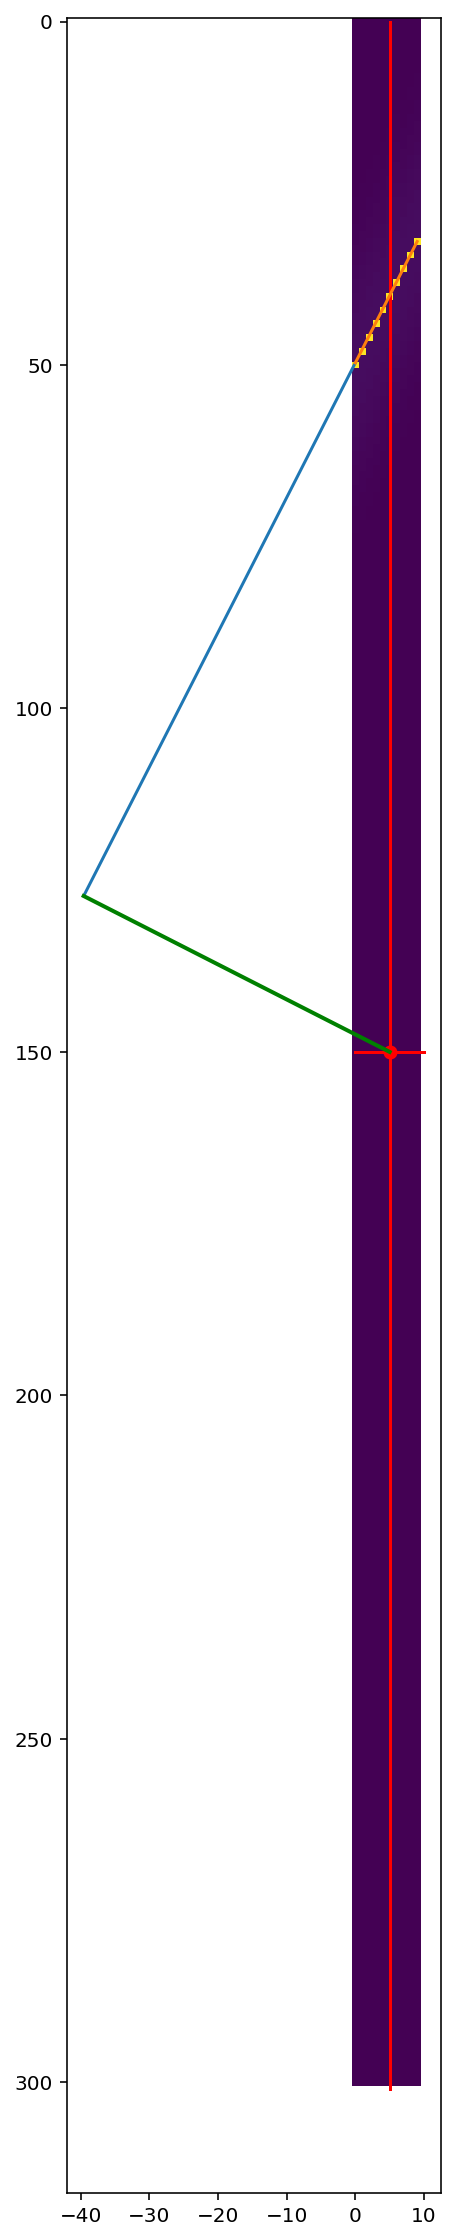

In [957]:

posterior = posterior.T
projection_angles = np.arange(-90, 90, 0.5)

sinogram = radon(posterior, theta=projection_angles, circle=False, preserve_range=True)
center_pixel = np.asarray((posterior.shape[1] // 2, posterior.shape[0] // 2))

n_pixels_from_center_ind, projection_angle_ind = np.unravel_index(
    indices=np.argmax(sinogram), shape=sinogram.shape
)

pixels_from_center = np.arange(-sinogram.shape[0] // 2, sinogram.shape[0] // 2)
projection_angle = projection_angles[projection_angle_ind]
n_pixels_from_center = pixels_from_center[n_pixels_from_center_ind]

projection_angle_radians = np.deg2rad(projection_angle)

plt.figure(figsize=(20, 20))

plt.imshow(posterior)
plt.scatter(center_pixel[0], center_pixel[1], color="red")
plt.plot(
    np.arange(posterior.shape[1] + 1),
    np.ones((posterior.shape[1] + 1,)) * center_pixel[1],
    color="red",
)
plt.plot(
    np.ones((posterior.shape[0] + 1,)) * center_pixel[0],
    np.arange(posterior.shape[0] + 1),
    color="red",
)


plt.plot(
    [
        center_pixel[0],
        center_pixel[0] + n_pixels_from_center * np.cos(-projection_angle_radians),
    ],
    [
        center_pixel[1],
        center_pixel[1] + n_pixels_from_center * np.sin(-projection_angle_radians),
    ],
    color="green",
    zorder=100,
    linewidth=2,
)


slope = -1.0 / np.tan(-projection_angle_radians)
intercept = (
    0,
    n_pixels_from_center / np.sin(-projection_angle_radians)
    - slope * center_pixel[0]
    + center_pixel[1],
)
point = (
    center_pixel[0] + n_pixels_from_center * np.cos(-projection_angle_radians),
    center_pixel[1] + n_pixels_from_center * np.sin(-projection_angle_radians),
)

plt.plot([intercept[0], point[0]], [intercept[1], point[1]])

plt.plot(
    np.arange(posterior.shape[1]), intercept[1] + slope * np.arange(posterior.shape[1])
)

# plt.xlim((0, posterior.shape[1]))
# plt.ylim((0, posterior.shape[0]))

(214,)


Text(0.5, 1.0, '0.7117057441826624')

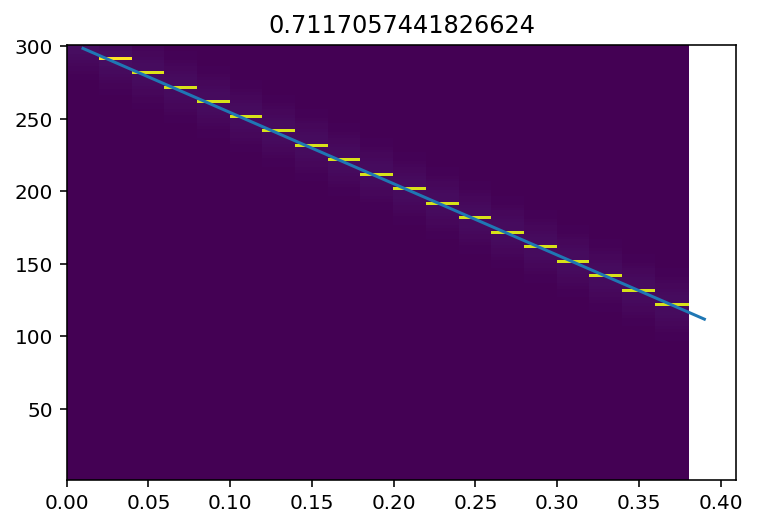

In [1107]:
from src.standard_decoder import detect_line_with_radon

dt = 0.020
dp = 2

starting_position = 300.0
velocity = -500
time = np.arange(20) * dt
true_replay_position = starting_position + velocity * time

place_bin_edges = np.arange(0, 301 + dp, dp)
place_bin_centers = place_bin_edges[:-1] + np.diff(place_bin_edges) / 2

likelihood = np.zeros((time.shape[0], place_bin_centers.shape[0]))
p_ind = np.digitize(true_replay_position, place_bin_edges.squeeze()[1:-1])
for t_ind, peak in enumerate(place_bin_centers[p_ind]):
    likelihood[t_ind, :] = multivariate_normal(mean=peak, cov=144).pdf(
        place_bin_centers.squeeze()
    )
t_ind = np.arange(len(time))
likelihood[(t_ind, p_ind)] = 1.0

posterior = normalize_to_posterior(likelihood)

start_position, velocity, radon_position, radon_score = detect_line_with_radon(
    posterior, dt, dp
)

t, p = np.meshgrid(time, place_bin_centers)
plt.pcolormesh(t, p, posterior.T)
plt.plot(time + dt / 2, radon_position)
plt.title(radon_score)

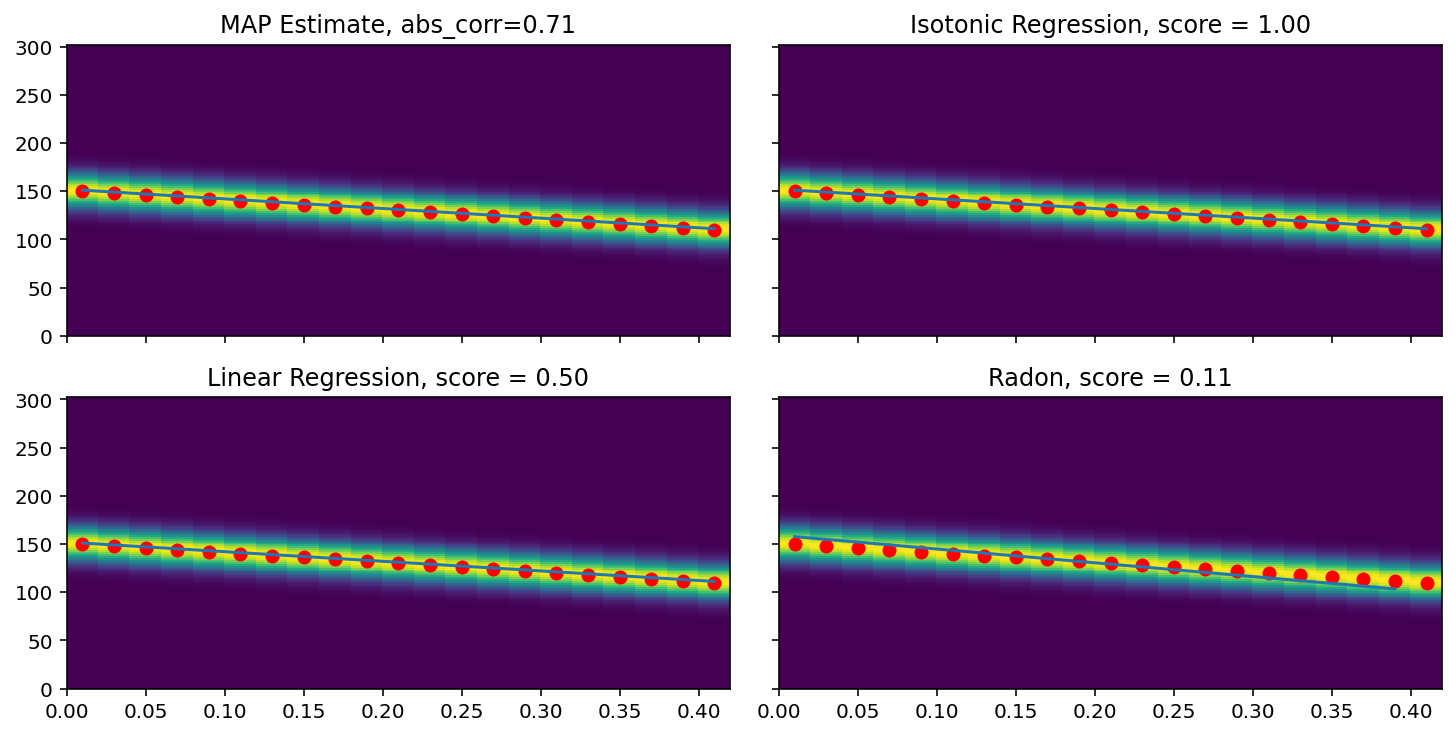

In [1130]:
from src.standard_decoder import test_standard_decoding

test_standard_decoding(use_gaussian=True, starting_position=150.0, velocity=-100)

In [27]:
classifier.place_bin_center_ind_to_edge_id_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3])

In [39]:
arm_to_edge_id = {"center_arm": [0], "right_arm": [2, 4], "left_arm": [1, 3]}
arm_to_edge_id

{'center_arm': [0], 'right_arm': [2, 4], 'left_arm': [1, 3]}

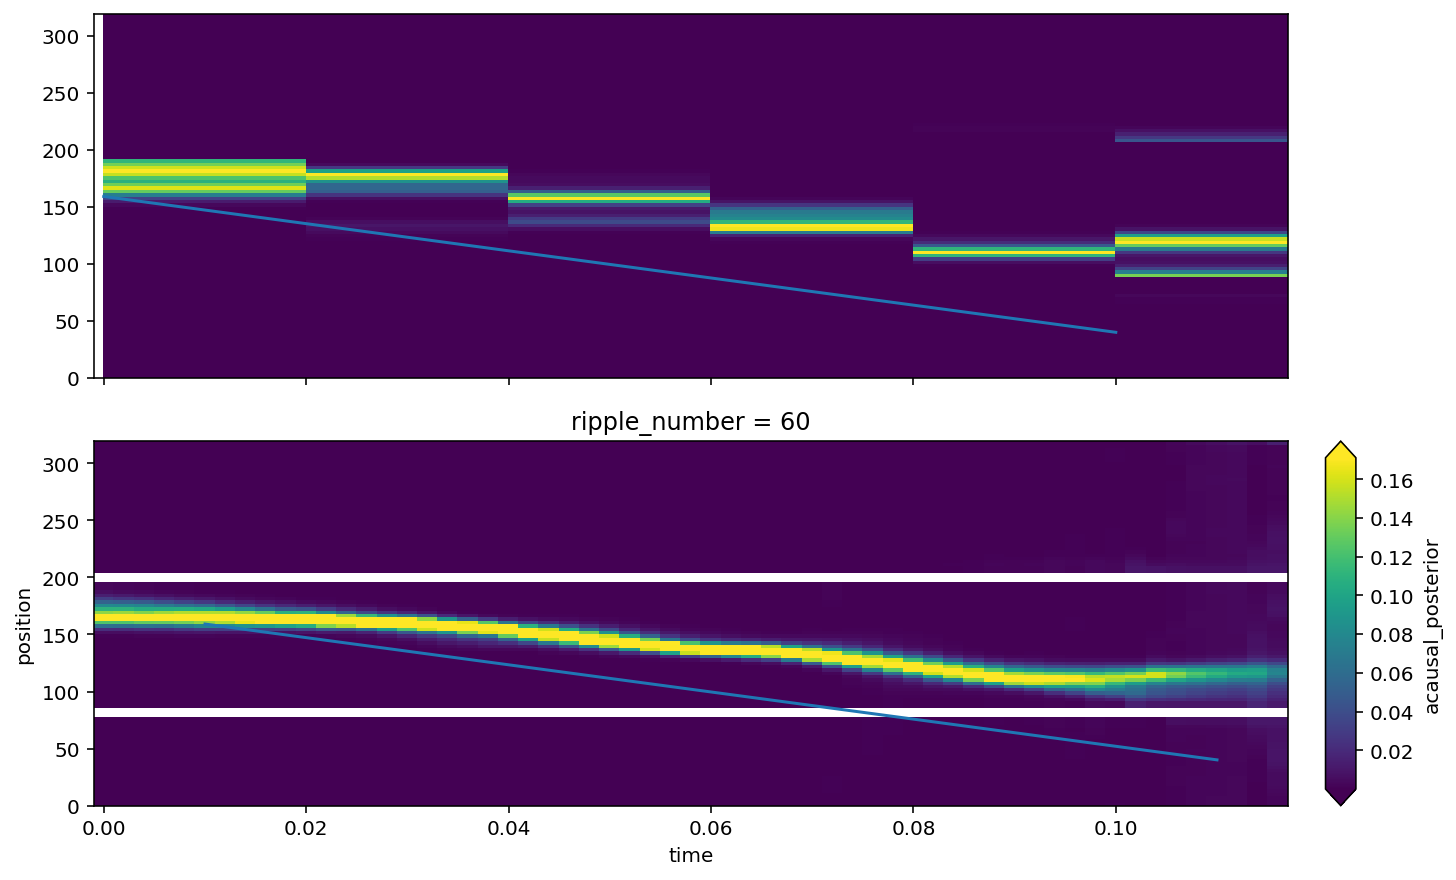

In [56]:
ripple_number = 60

dt = 0.020

start_time, end_time = (
    ripple_times.loc[ripple_number].start_time / np.timedelta64(1, "s"),
    ripple_times.loc[ripple_number].end_time / np.timedelta64(1, "s"),
)

likelihood, time = predict_mark_likelihood(
    start_time,
    end_time,
    place_bin_centers,
    occupancy,
    joint_pdf_models,
    multiunit_dfs,
    ground_process_intensities,
    mean_rates,
    is_track_interior,
    dt=dt,
)
posterior = normalize_to_posterior(likelihood)


dp = np.mean(np.diff(place_bin_edges.squeeze())[is_track_interior])
arms = ["left_arm", "right_arm"]
params = []

for ind, arm in enumerate(arms):
    is_arm = np.isin(
        classifier.place_bin_center_ind_to_edge_id_, arm_to_edge_id["center_arm"]
    ) | np.isin(classifier.place_bin_center_ind_to_edge_id_, arm_to_edge_id[arm])
    params.append(detect_line_with_radon(posterior[:, is_arm], dt, dp))

if params[0][-1] >= params[1][-1]:
    max_ind = 0
else:
    max_ind = 1

(start_position, estimated_velocity, radon_prediction, radon_score,) = params[max_ind]


time_bin_edges = np.append(time, time[-1] + dt)
t, p = np.meshgrid(time_bin_edges, place_bin_edges)

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)

axes[0].pcolormesh(t, p, likelihood.T)
axes[0].plot(time, radon_prediction)

state_space_posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, "s"))
)
state_space_posterior.sum("state", skipna=False).plot(
    x="time", y="position", robust=True, ax=axes[1]
)
axes[1].plot(time + dt / 2, radon_prediction)